In [ ]:
import re

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

import spacy
from nltk.stem import PorterStemmer

nlp = spacy.load('en_core_web_sm')

In [ ]:
# Reading the training and testing dataset
df_train = pd.read_csv('')
df_test = pd.read_csv('')

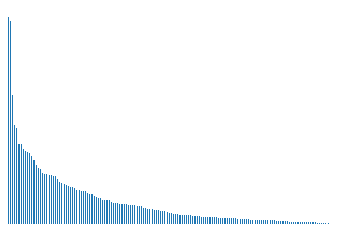

In [ ]:
# Distribution of data among the category
df_train['category'].value_counts().plot(kind='bar')
plt.axis('off')
plt.show()

In [ ]:
df_train['category'].value_counts()

cs-LG        23414
cs-CV        22943
quant-ph-    14561
cs-CL        11143
hep-ph-      10863
             ...  
q-fin-EC        17
astro-ph-        7
q-alg-           2
alg-geom-        1
funct-an-        1
Name: category, Length: 156, dtype: int64

**Observation**:
The class is highly imbalanced and there are few classes which has very few records


### Data Preprocessing

In [ ]:
ps = PorterStemmer()

In [ ]:
def clean_abstract(text):
  text = re.sub('[^a-z\s]', ' ', text.lower())
  text = [i.lower() for i in text.split() if i not in nlp.Defaults.stop_words]
  text = [ps.stem(i) for i in text]
  text = ' '.join(text)
  text.replace('\n',' ')
  return text

In [ ]:
df_train['abstract'] = df_train['abstract'].apply(clean_abstract)
df_test['abstract'] = df_test['abstract'].apply(clean_abstract)

##### Text vectorization

In [ ]:
X_train, y_train = df_train['abstract'],df_train['category']
X_test, y_test = df_test['abstract'],df_test['category']

In [ ]:
label_encoder = LabelEncoder().fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
tfidf = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,1))

In [ ]:
tfidf_vectorizer = tfidf.fit(X_train)

X_train = tfidf_vectorizer.transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

### Classification using under sampling and over sampling

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
def sampling_strategy(y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = {k:v for k,v in dict(Counter(y)).items() if v > n_samples}
    elif t == 'minority':
        # Since SMOTE depends on KNN, filtering out those samples that occur less than 10 times
        target_classes = {k:v for k,v in dict(Counter(y)).items() if v < n_samples and v > 10}
    sampling_strategy = {k:n_samples for k,v in target_classes.items()}
    return sampling_strategy

In [ ]:
over_sampler_ss = sampling_strategy(y_train,1000,t='minority')

In [ ]:
under_sampler_ss = sampling_strategy(y_train,8000,t='majority')

In [ ]:
over = SMOTE(sampling_strategy=over_sampler_ss)

In [ ]:
under = RandomUnderSampler(sampling_strategy=under_sampler_ss, random_state=42)

In [ ]:
X_over, y_over = over.fit_resample(X_train, y_train)

In [ ]:
X_under, y_under = under.fit_resample(X_train, y_train)

In [ ]:
svc_s = LinearSVC(max_iter=1000)

In [ ]:
print(svc_s.__class__.__name__)
svc_s.fit(X_under, y_under)
y_pred = svc_s.predict(X_test)
print('F1 Score : {}'.format(f1_score(y_test, y_pred, average='micro')))

LinearSVC
F1 Score : 0.6503092614590587
